In [1]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install tweedledum

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------------------------ --------------- 0.7/1.1 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 17.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Diagonal, GroverOperator, UnitaryGate, QFT, XOR
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler


In [4]:
service = QiskitRuntimeService(channel="ibm_quantum", instance="rpi-rensselaer/general/general", token='12dde051eed1072fe87192b52b500f8925ed4c0543679dfffefeeb95da9901eca6cf1870804b7c93a9396040fc855ac57f91f8167741467b2357e37a6b2fda50')
backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(backend)
simulator = AerSimulator()

'''backend_properties = backend.properties()
qub = {}
for qubit, qubit_props in enumerate(backend_properties.qubits):
    for prop in qubit_props:
        if prop.name == 'readout_error':
            qub[qubit] = prop.value
error_sort = list(dict(sorted(qub.items(), key=lambda item: item[1])).keys())'''

"backend_properties = backend.properties()\nqub = {}\nfor qubit, qubit_props in enumerate(backend_properties.qubits):\n    for prop in qubit_props:\n        if prop.name == 'readout_error':\n            qub[qubit] = prop.value\nerror_sort = list(dict(sorted(qub.items(), key=lambda item: item[1])).keys())"

In [5]:
def plot_1(hist, counts):
    return plot_histogram([hist, counts], legend=['simulation', 'actual'], color=['#1f77b4', '#ff7f0e'])

def plot_2(hist, counts, hist_1, counts_1, txt1, txt2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_histogram([hist, counts], color=['#1f77b4', '#ff7f0e'], ax=axs[0])
    axs[0].set_title(txt1)
    plot_histogram([hist_1, counts_1], legend=['simulation', 'actual'], color=['#1f77b4', '#ff7f0e'], ax=axs[1])
    axs[1].set_title(txt2)
    plt.tight_layout()
    return plt.show()

def run_sim(qc):
    transpiled_qc = transpile(qc, simulator)
    job = simulator.run(transpiled_qc, shots=100000)
    hist = job.result().get_counts()
    return hist

def run_act(qc):
    #initial_layout = {qc.qubits[i]: error_sort[i] for i in range(qc.num_qubits)}
    #transpiled_qc = transpile(qc, backend=backend, initial_layout=initial_layout)
    transpiled_qc = transpile(qc, backend=backend)
    #job = sampler.run([transpiled_qc], shots=100000)
    job = backend.run([transpiled_qc], shots=100000)
    counts = job.result().get_counts()
    #counts = job.result()[0].data.meas.get_counts()
    #counts_1 = {k: v for k, v in counts.items() if v >= 400}
    
    return counts

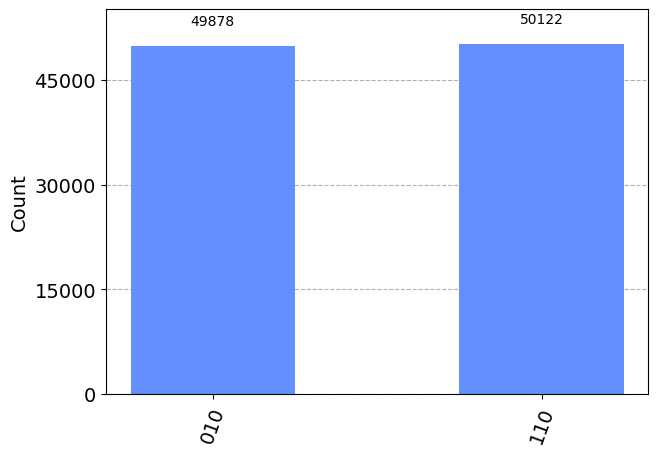

In [6]:
# Test on Grover's algorithm
from qiskit.circuit.library import Diagonal, GroverOperator
from qiskit.circuit.library import QFT

def grover_operator(n_iterations):
    oracle = Diagonal([1,-1,-1,1,-1,1,1,-1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    return grover_it

t=3
n=3

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t, t)
for qubit in range(t+n):
    qc.h(qubit)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
plot_histogram(hist)

In [7]:
from qiskit.circuit.classicalfunction import classical_function
from qiskit.circuit.classicalfunction.types import Int1

@classical_function
def grover_oracle(a: Int1, b: Int1, c: Int1, d: Int1, e: Int1) -> Int1:
    s = ((a and b or not c) and not (not d or (not e or not a) or ((b and not c) or (not b and c)))) or (not (a and b or not c) and (not d or (e and not a) or ((b and not c) or (not b and c))))
    return not s
    return not((not(a) or b) and c)
    return ((a and not b) or (not a and b) and not c) or (not (a and not b) or (not a and b) and c)

@classical_function
def grover_oracle1(a: Int1, b: Int1, c: Int1, d: Int1, e: Int1, f: Int1, g: Int1, h: Int1, i: Int1) -> Int1:
    return ((a and b) or (a and c and i) or (a and f) or (a and h) or (b and f) or (b and h) or d or e or g or (h and i))

quantum_circuit = grover_oracle1.synth(registerless=False)
oracle_gate = quantum_circuit.to_gate()

def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate()

def rr(qc,n):
    state = Statevector.from_label('0' * n) 
    state = state.evolve(qc)
    print("Statevector:")
    for i, amplitude in enumerate(state.data):
        print(f"|{i:0{n}b}>: {amplitude}")


Register Output = 0
Theta = 0.00000
No. of Solutions = 0.0
Error < 16.00


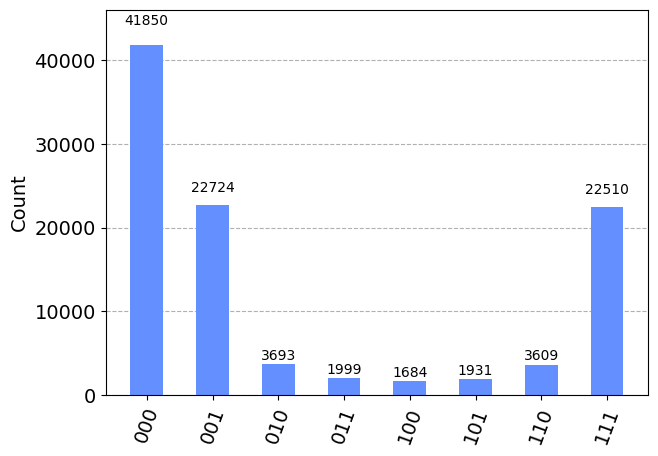

In [15]:
def grover_operator(n_iterations,n):
    grover_it = QuantumCircuit(n+1)
    for i in range(n_iterations):
        grover_it.append(oracle_gate, range(n+1))
        grover_it.append(diffuser(n), range(n))
    return grover_it.to_gate()

t=3
n=9

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t+1, t)
qc.h(range(t+n))
qc.x(t+n)
qc.h(t+n)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations,n).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t+1)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t-1
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
#err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)
plot_histogram(hist)

Register Output = 15
Theta = 5.89049
No. of Solutions = 19.5
Error < 14.49


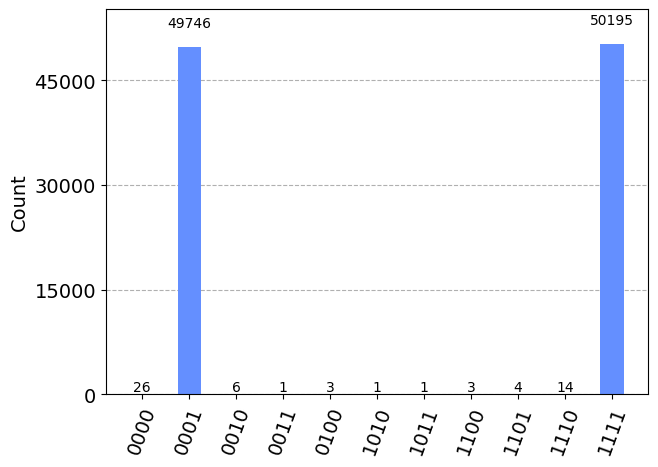

In [11]:
def grover_operator(n_iterations,n):
    grover_it = QuantumCircuit(n+1)
    for i in range(n_iterations):
        grover_it.append(oracle_gate, range(n+1))
        grover_it.append(diffuser(n), range(n))
    return grover_it.to_gate()

t=4
n=9

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t+1, t)
qc.h(range(t+n))
qc.x(t + n)
qc.h(t + n)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations,n).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t+1)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t - 1 
err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)
plot_histogram(hist)

Register Output = 30
Theta = 5.89049
No. of Solutions = 19.5
Error < 6.74


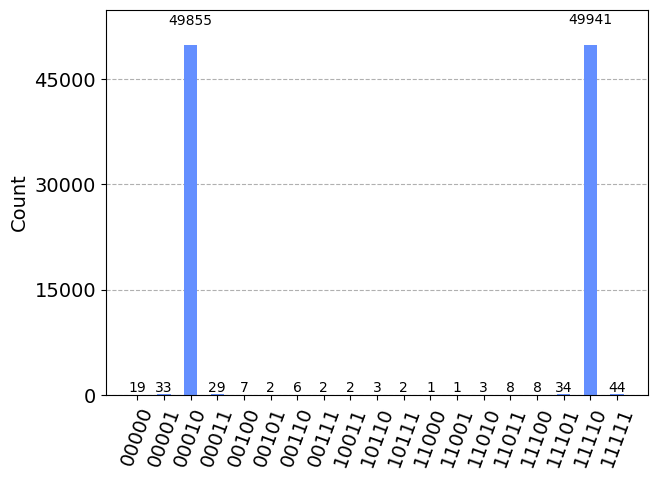

In [12]:
def grover_operator(n_iterations,n):
    grover_it = QuantumCircuit(n+1)
    for i in range(n_iterations):
        grover_it.append(oracle_gate, range(n+1))
        grover_it.append(diffuser(n), range(n))
    return grover_it.to_gate()

t=5
n=9

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t+1, t)
qc.h(range(t+n))
qc.x(t + n)
qc.h(t + n)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations,n).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t+1)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t - 1 
err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)
plot_histogram(hist)

Register Output = 4
Theta = 0.39270
No. of Solutions = 19.5
Error < 3.25


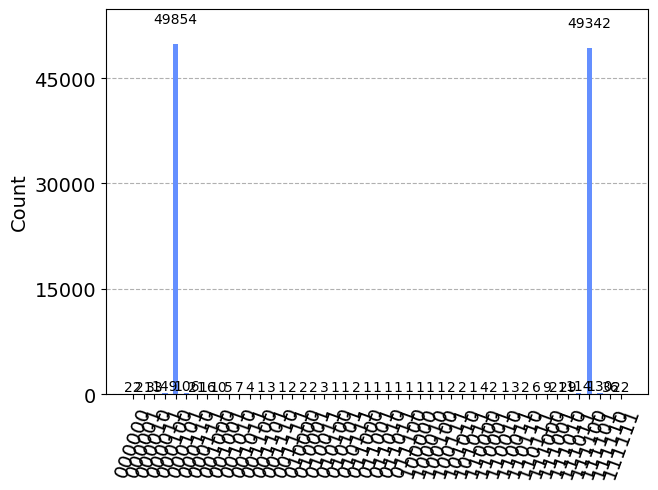

In [13]:
def grover_operator(n_iterations,n):
    grover_it = QuantumCircuit(n+1)
    for i in range(n_iterations):
        grover_it.append(oracle_gate, range(n+1))
        grover_it.append(diffuser(n), range(n))
    return grover_it.to_gate()

t=6
n=9

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t+1, t)
qc.h(range(t+n))
qc.x(t + n)
qc.h(t + n)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations,n).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t+1)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t - 1 
err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)
plot_histogram(hist)

In [24]:
@classical_function
def xor(a: Int1, b: Int1) -> Int1:
    return (a and not b) or (not a and b)

@classical_function
def grover_oracle2(a: Int1, b: Int1, c: Int1) -> Int1:
    return not (xor(xor(a,b),c))

quantum_circuit = grover_oracle2.synth(registerless=False)
oracle_gate = quantum_circuit.to_gate()

def grover_operator(n_iterations,n):
    grover_it = QuantumCircuit(n+1)
    for i in range(n_iterations):
        grover_it.append(oracle_gate, range(n+1))
        grover_it.append(diffuser(n), range(n))
    return grover_it.to_gate()

t=3
n=3

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t+1, t)
qc.h(range(t+n))
qc.x(t + n)
qc.h(t + n)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations,n).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t+1)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)

measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t - 1 
err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)

ClassicalFunctionParseError: "Unknown node: <class 'ast.Call'>"

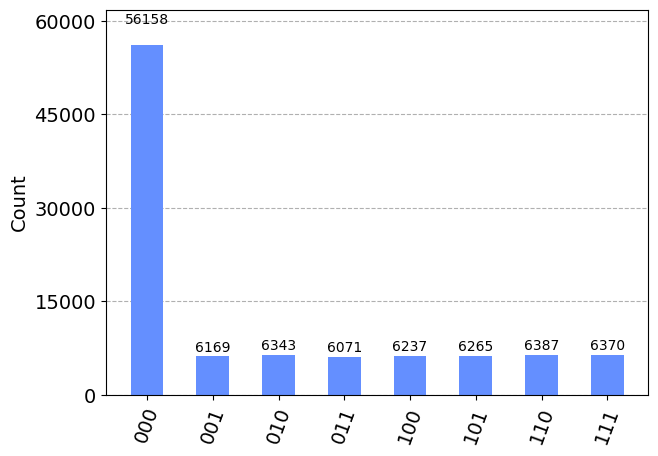

In [93]:
oracle = Diagonal([1,-1,-1,1,-1,1,1,-1])
grover_it = GroverOperator(oracle).repeat(1)


grover_it.measure_all()
hist = run_sim(grover_it)
plot_histogram(hist)

In [74]:
# Test on Grover's algorithm
from qiskit.circuit.library import Diagonal, GroverOperator
from qiskit.circuit.library import QFT

def grover_operator(n_iterations):
    oracle = Diagonal([1,1,-1,1,1,1,1,-1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    return grover_it

t=3
n=3

qft_dagger = QFT(t, inverse=True).to_gate()
qc = QuantumCircuit(n+t, t)
for qubit in range(t+n):
    qc.h(qubit)
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

hist = run_sim(qc)
#hist = run_act(qc)
#plot_histogram(hist)

measured_str = max(hist, key=hist.get)
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")
m = t - 1 
err = (2*math.sqrt(M*N) + N/(2**(m+1)))*(2**(-m-1))
print("Error < %.2f" % err)

Register Output = 1
Theta = 0.78540
No. of Solutions = 1.2
Error < 0.89
